In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load experimental data
df = pd.read_csv("ar-601_fingers_parameters_Khusnutdinov.txt", comment='#', header=None);
# Correct scale
df = df.multiply(0.01);
# Select data for fingers
thumbd = df.loc[0:6]
indexd = df.loc[7:13]
middled = df.loc[14:19]
ringd = df.loc[20:26]
pinkyd = df.loc[27:]

In [3]:
# Derive equations
import sympy as sy

angle, x1, x2, y1, y2, k1, k2, offset1, offset2, l1, l2, l3 =  sy.symbols('angle x1 y1 x2 y2 k1 k2 offset1 offset2 l1 l2 l3')
mimic1 = k1*angle + offset1
x1 = l1*sy.sin(angle) + l2*sy.sin(mimic1)
y1 = l1*sy.cos(angle) + l2*sy.cos(mimic1)
mimic2 = k2*mimic1 + offset2
x2 = x1 + l3*sy.sin(mimic2)
y2 = y1 + l3*sy.cos(mimic2)

In [4]:
# Data, functions and constants

# One jointed constants and parameters guess
j1_l1 = 0.025
j1_l2 = 0.022
j1_offset = 0
j1_k = 1
# Two jointed constants and parameters guess
j2_l1 = 0.025
j2_l2 = 0.025
j2_l3 = 0.022 
j2_offset1 = 0
j2_offset2 = 0
j2_k1 = 1
j2_k2 = 1
# Data 
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
finger_joints = [1, 2, 2, 2, 1]
finger_data = [thumbd.values, indexd.values, middled.values, ringd.values, pinkyd.values]
# Functions
f_1_joint_x = sy.lambdify([k1, offset1, l1, l2, angle], x1)
f_1_joint_y = sy.lambdify([k1, offset1, l1, l2, angle], y1)
f_2_joint_x = sy.lambdify([k1, offset1, k2, offset2, l1, l2, l3, angle], x2)
f_2_joint_y = sy.lambdify([k1, offset1, k2, offset2, l1, l2, l3, angle], y2)

def j1_model(angle, k1, offset1):
    return np.column_stack((f_1_joint_x(k1, offset1, j1_l1, j1_l2, angle),
            f_1_joint_y(k1, offset1, j1_l1, j1_l2, angle)))

def j1_err(u, angle, experiment):
    pred = j1_model(angle, u[0], u[1])
    diff = experiment - pred
    n_exp = len(experiment)
    err = (1/n_exp) * sum(1/2 * np.sum(diff**2, axis = 1))
    return err
    return diff

def j2_model(angle, k1, offset1, k2, offset2):
    return np.column_stack((f_2_joint_x(k1, offset1, k2, offset2, j2_l1, j2_l2, j2_l3, angle),
            f_2_joint_y(k1, offset1, k2, offset2, j2_l1, j2_l2, j2_l3, angle)))

def j2_err(u, angle, experiment):
    pred = j2_model(angle, u[0], u[1], u[2], u[3])
    diff = experiment - pred
    n_exp = len(experiment)
    err = (1/n_exp) * sum(1/2 * np.sum(diff**2, axis = 1))
    return err

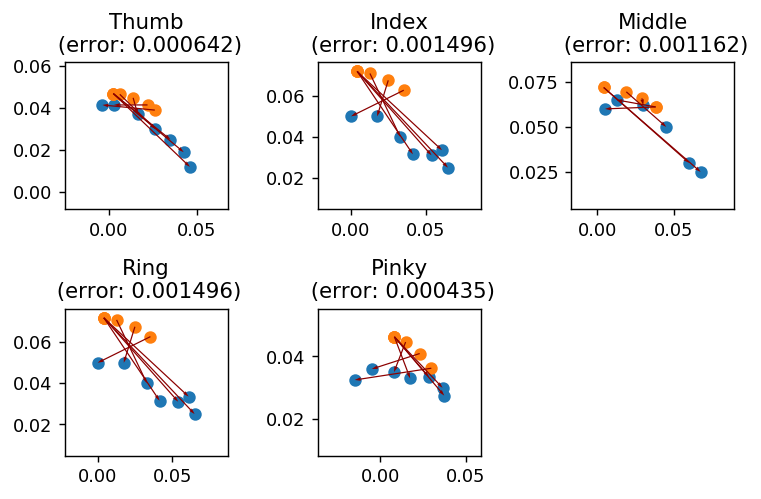

In [5]:
# Plot experimental data with default parameter fit
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=128)
axs = axs.flatten()
for i in range(0,5):
    axs[i].scatter(finger_data[i][:,0], finger_data[i][:,1])
    model_out = []
    if finger_joints[i] == 1:
        model_out = j1_model(finger_data[i][:,2], j1_k, j1_offset)
    else:
        model_out = j2_model(finger_data[i][:,2], j2_k1, j2_offset1, j2_k2, j2_offset2)
    axs[i].scatter(model_out[:,0], model_out[:,1])
    diff = finger_data[i][:,0:2] - model_out
    X_, Y_ = zip(*(model_out))
    U_, V_ = zip(*diff)
    axs[i].quiver(X_, Y_, U_, V_, angles='xy', scale_units='xy', scale=1, color = 'darkred')
    n_exp = len(finger_data[i])
    err = (1/n_exp) * sum(1/2 * np.sum(diff**2, axis = 1))
    axs[i].set_title(finger_names[i] + "\n (error: %f)" % err)
axs[5].set_visible(False)
fig.tight_layout()
plt.axis('equal')
plt.show()
#print(model_out)
#finger_data[i][2]
#pred = np.concatenate(j1_model(finger_data[i][2].values, j1_k, j1_offset), axis=1)
#
#fig, axs = plt.subplots(nrows=2, ncols=3, dpi=120)
#axs = axs.flatten()

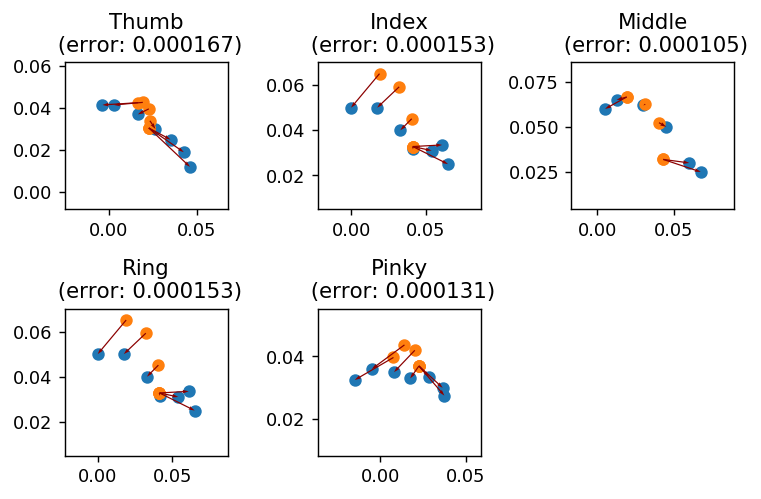

In [6]:
from scipy.optimize import least_squares

opt_params = []
for i in range(0,5):
    f = j1_err
    guess = [j1_k, j1_offset]
    if finger_joints[i] == 2:
        f = j2_err
        guess = [j2_k1, j2_offset1, j2_k2, j2_offset2]
    opt_params.append(least_squares(f, guess, args=(finger_data[i][:, 2], finger_data[i][:, 0:2])))

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=128)
axs = axs.flatten()
for i in range(0,5):
    axs[i].scatter(finger_data[i][:,0], finger_data[i][:,1])
    if finger_joints[i] == 1:
        model_out = j1_model(finger_data[i][:,2], opt_params[i].x[0], opt_params[i].x[1])
    else:
        model_out = j2_model(finger_data[i][:,2], opt_params[i].x[0], opt_params[i].x[1],opt_params[i].x[2],opt_params[i].x[3])
    axs[i].scatter(model_out[:,0], model_out[:,1])
    diff = finger_data[i][:,0:2] - model_out
    X_, Y_ = zip(*(model_out))
    U_, V_ = zip(*diff)
    axs[i].quiver(X_, Y_, U_, V_, angles='xy', scale_units='xy', scale=1, color = 'darkred')
    n_exp = len(finger_data[i])
    err = (1/n_exp) * sum(1/2 * np.sum(diff**2, axis = 1))
    axs[i].set_title(finger_names[i] + "\n (error: %f)" % err)
axs[5].set_visible(False)
fig.tight_layout()
plt.axis('equal')
plt.show()